# Jay and Kyle:  Film Industry Consultants

![Jerry](https://media.giphy.com/media/Bi6FcO7UoutWM/giphy.gif "popcorn")


# Business Problem:
Microsoft (NASDAQ: MSFT) has decided to enter the original video content production and streaming business similar to Netflix and Amazon Prime. The goal of this project is to analyze the movie data, determine the types of films that has shown success, and based on that make recommendations to Microsoft on the types of film ventures to pursue.

We assumed that Microsoft will be investing in and producing full feature films. The films will be available for distribution in movie theaters world-wide. At the same time, we assumed that Microsoft will launch a streaming platform service like Netflix and Amazon Prime, first starting out in the U.S., featuring Microsoft original films.

# Questions of Interest:
1. Which genre should we start with? (Which genre will generate the highest return on investment (ROI)?)
1. What month is the right time to release to maximize ROI of different genres?
1. What is ideal crew to assemble? (Which directors, writers, and actors have the highest ROI?)
1. Who are the directors that can make the highest grossing flims, regardless of budget? 

We applied the threshold of film gross revenues of USD 20 million and USD 100 million to classify movies in independent, mainstream, and blockbuster categories.

# Let's get set up!

In order to run our analysis we first need to import a variety of modules, set our plot settings and establish a connnection to sequel.

In [1]:
#Importing modules
import pandas as pd
import mysql.connector
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import sys
import datetime as dt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# import for interactive graphs
import mplcursors

In [4]:
# Magic Command
%matplotlib inline  
# for now, will change to qt for interactive chart

In [5]:
# Establishing connection to mysql database
con = mysql.connector.connect(user = 'hbs-student', password = 'super-secure-password?',
                              host = 'hbs-ds-060120.c1doesqrid0e.us-east-1.rds.amazonaws.com',
                              database = 'movies')

## Question #1:  Which genre should we start with?

It is critical to choose the genre for a movie.  We are looking for a steady revenue stream for this venture so our relevant metric will be Return on Investment (ROI).  Due to data constraints, we won't actually have the ROI realied by the studio, but instead the ROI based on the worldwide gross take. It's a bit contrived but it should be a pretty good proxy for profitability.

In [6]:
#Set the mysql query 
query = """
SELECT itb.*, bmg.*, tmb.release_date, tmb.worldwide_gross, tmb.production_budget
FROM movies.imdb_title_basics itb
JOIN movies.bom_movie_gross bmg
ON itb.primary_title = bmg.title
JOIN movies.tn_movie_budgets tmb
ON tmb.movie = bmg.title
"""
# Reading query output into df
df = pd.read_sql_query(query, con)

## Time for some data cleaning

In [7]:
# Data cleaning and melt to get 'genre' string data into individual row entries.
df_genre = df.genres.apply(lambda x: x.split(',')).apply(pd.Series)\
            .merge(df, left_index = True, right_index = True)\
            .drop(["genres", 'primary_title', 'title'], axis = 1)\
            .melt(id_vars = ['tconst', 'original_title', 'start_year', 'runtime_minutes', 'studio',\
                 'domestic_gross', 'foreign_gross', 'year', 'release_date', 'worldwide_gross', 'production_budget'],\
                  value_name = "genre")\
            .dropna(subset=['genre'])\
            .sort_values(by = 'genre')

# Split string on ',' into list and creating dataframe
# Merging new data fram with original df
# Dropping redunant columns
# Melting new genre columns into individual row entries
# Dropping rows with null 'genre' column 
# Sorting by genre

In [8]:
# Reformatting columns with string variables to int
dollar_string = ['worldwide_gross', 'production_budget']

for string in dollar_string:
    df_genre[string] = df_genre[string].str.replace("$", "").str.replace(',','').astype(int)

In [9]:
# Converting release date to datetime obkect and creating relevant columns
df_genre['release_date_dt'] = df_genre['release_date'].apply(lambda x: dt.datetime.strptime(x,'%b %d, %Y'))

# Getting column for month out as number 
df_genre['release_month'] = df_genre['release_date_dt'].apply(lambda x: x.month)

# Creating column for release season
season_dict = {1: 'winter', 2:'winter', 3:"spring", 4:"spring", 5:'spring',6:'summer', 7:'summer',8:'summer', 9:'fall',\
              10:'fall', 11:'fall', 12:'winter'}
df_genre['release_season'] = df_genre['release_month'].apply(lambda x: season_dict[x])

In [10]:
# Caluculating new columns ('roi' = Return on Investment)
df_genre['roi'] = (df_genre.worldwide_gross - df_genre.production_budget)/df_genre.production_budget

In [11]:
# Filtering out movies with WW_Gross less than $1M and production budget of > $1M
df_genre_f = df_genre.loc[(df_genre['worldwide_gross'] > 1000000) & (df_genre['production_budget'] > 1000000)]

In [12]:
# Dropping non-null, but uncategorized genre movies
df_genre_f = df_genre_f.drop(df_genre_f.loc[df_genre_f['genre'] == ''].index)

Text(0.5, 1.0, 'ROI per Genre')

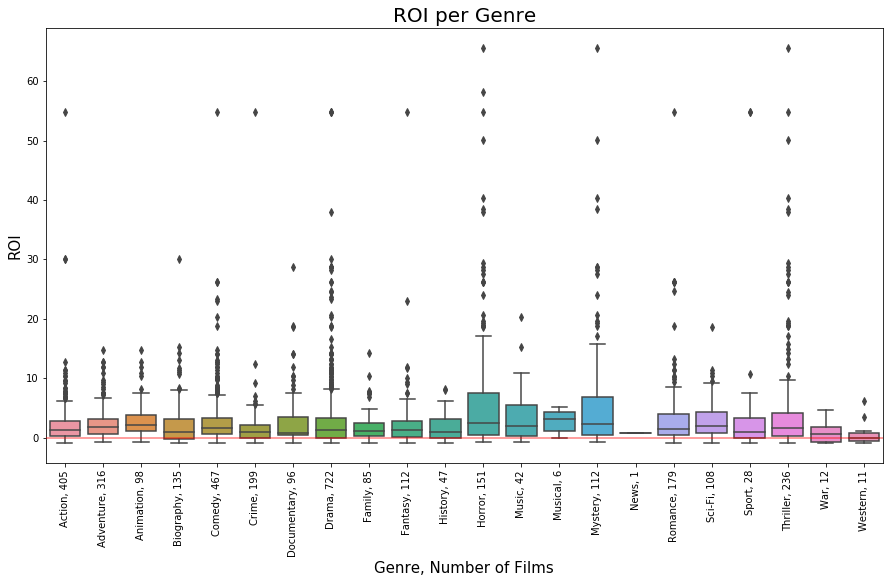

In [13]:
# Setting up a boxplot for ROI by Genre 
plt.figure(figsize = (15,8))
ax = sns.boxplot(x = "genre", y = "roi", data = df_genre_f)

# Setting xtick labels to include genre and movie count
xt = []
genre_counts = df_genre_f.groupby('genre').count()['tconst']
genre_unique = df_genre_f.genre.unique()
for a in genre_unique:
    xt.append(f'{a}, {genre_counts[a]}')

# Finishing the plot
ax.axhline(y = 0, color = 'red', zorder = 100, alpha = .5)
ax.set_xticklabels(xt, rotation = 90, horizontalalignment = 'center')
#plt.ylim( top = 18)
plt.xlabel('Genre, Number of Films', fontsize = 15)
plt.ylabel('ROI', fontsize = 15)
plt.title('ROI per Genre', fontsize = 20)

Let's check out the mean ROI's to get a better sense of the expected value of a return

Text(0.5, 1.0, 'Mean ROI per Genre')

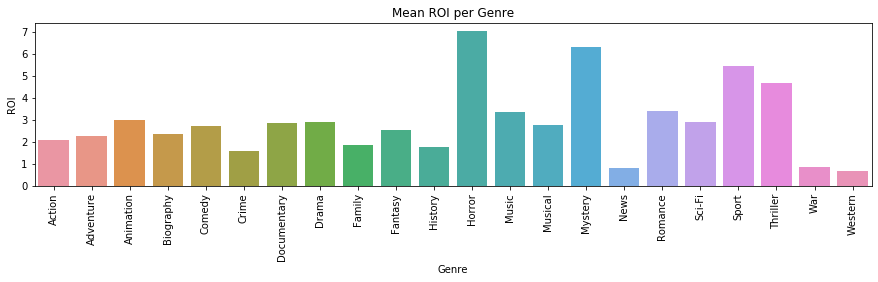

In [14]:
#Plotting the mean ROI across genre's
gb_genre = (df_genre_f.groupby(['genre']).mean())
xvals = list(range(1, len(gb_genre) + 1))
yvals = gb_genre['roi'].values
labels = gb_genre.index

# Plotting
plt.figure(figsize = (15,3))
genre_plot = sns.barplot(x = labels, y = yvals, orient = 'v')
genre_plot.set_xticklabels(genre_plot.get_xticklabels(), rotation = 90, horizontalalignment = 'center')

# Labeling 
plt.xlabel('Genre')
plt.ylabel('ROI')
plt.title('Mean ROI per Genre')

So, it looks 'Horror' is an appealing genre.  Let's take a look at normalized distribution plots to get a better sense of the probability of 'hitting a home run'. 

In [15]:
# Filtering out outliers for plotting purposes
df_genre_f_dg =  df_genre_f.loc[(df_genre['roi'] < 20)]

In [16]:
# Dropping genres with fewer than 20 entries in order to make KDE plots useful
genre_drop_list = ['News', 'War', 'Musical', 'Western']
for gen in genre_drop_list:
    df_genre_f_dg = df_genre_f_dg.drop(df_genre_f_dg[df_genre_f_dg['genre'] == gen].index)


Text(0.5, 0, 'ROI')

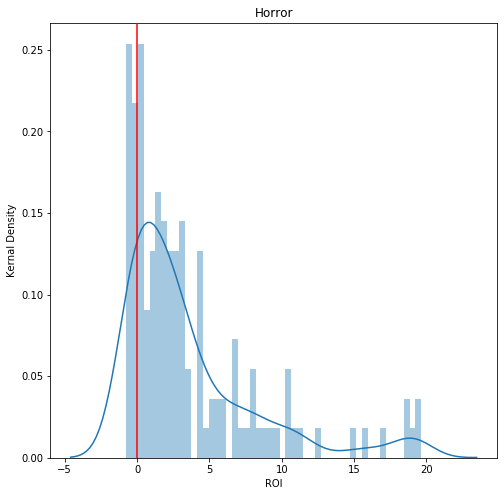

In [17]:
# Plotting KDE and Normalized Histograms for specified genre

# Genre choice : 'Action' 'Adventure' 'Animation' 'Biography' 'Comedy' 'Crime''Documentary' 'Drama' 'Family' 'Fantasy' 'History' 
                #'Horror' 'Music' 'Mystery' 'Romance' 'Sci-Fi' 'Sport' 'Thriller'

genre_choice = 'Horror'

# Building histogram data for each genre
genre_list = df_genre_f_dg.genre.unique()
total_dict = {}
for genre_type in genre_list: 
    total_dict[genre_type] = df_genre_f_dg.loc[df_genre_f_dg.genre == genre_type][['tconst', 'roi', 'genre']]

# Genre Choice Set up
values = list(range(0,len(genre_list)))
dictionary = dict(zip(genre_list, values))

#Pulling specified genre data
indexer = dictionary[genre_choice]   
g = total_dict[genre_list[indexer]]['roi']

#Finish plotting normalized histogram and KDE
y=g.tolist()
new_fig = plt.figure(figsize=(8,8))
ax = sns.distplot(y, bins =50, kde=1)
ax.axvline(x=0,ymin=0, ymax=1, color='red', zorder =100, alpha = 1)
plt.title(genre_list[indexer])
plt.ylabel('Kernal Density')
plt.xlabel('ROI')

Text(0.5, 8.959999999999773, 'ROI')

<Figure size 1440x576 with 0 Axes>

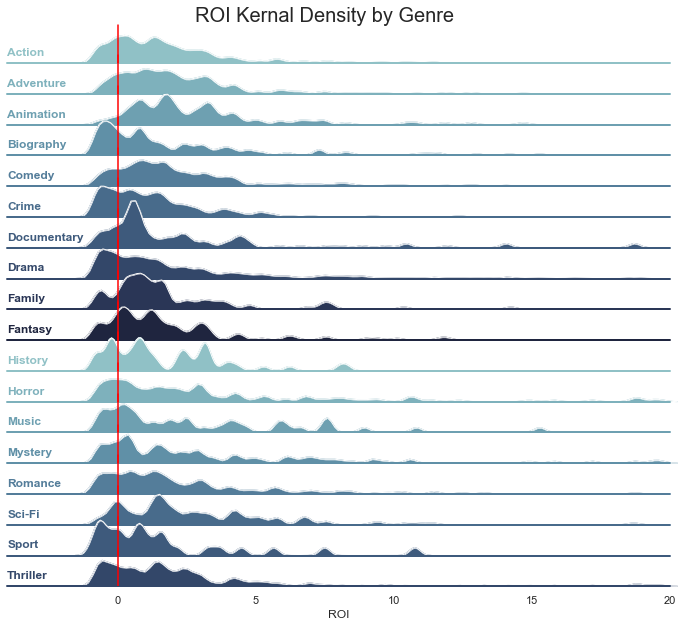

In [18]:
# It is helpful to plot all the genre KDEs on top of each other to compare odds of making a high ROI movie
# Ridge plot documentation from: https://seaborn.pydata.org/examples/kde_ridgeplot
plotdf = df_genre_f_dg[['genre', 'roi']]
plotdf = plotdf.reset_index()

plt.figure(figsize=(20,8))
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

#Set palette and FacetGrid, from SNS documentation
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(plotdf, row="genre", hue="genre", aspect=20, height=.5, palette=pal)

# Draw the densities in a few steps, from SNS documentation
g.map(sns.kdeplot, "roi", clip_on=False, shade=True, alpha=1, lw=1, bw=.2)
g.map(sns.kdeplot, "roi", clip_on=False, color="w", lw=1, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)
g.map(plt.axvline, x=0,ymin=-.10, ymax=.75, color='red', zorder =100, alpha = 1)

# Define and use a simple function to label the plot in axes coordinates, from SNS documentation
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "genre")

# Set the subplots to overlap, from SNS documentation
g.fig.subplots_adjust(hspace=-.4)
g.set(ylim=(0, .5))
g.set(xlim=(-4, 20))

# Remove axes details that don't play well with overlap, from SNS documentation
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)
plt.text(7.5, 5.5, 'ROI Kernal Density by Genre',
         horizontalalignment='center',
         fontsize=20)
plt.xlabel('ROI')



# Q1. Genre? : Answer = Horror
I think we can confirm that Horror is an attractive genre to go after. Happy times. 
![Pennywise](https://media.giphy.com/media/xT9IgvEOwRzUcZDRiU/giphy.gif "IT")

## Question 2: What is the ideal month to release?

Horror films seem like an interesting way forward but results could be sensitive to when the film is released.  Let's figure out when the best time to release a Horror movie is. 

First, let's just get a sense of the general case. When is demand for movies the highest?

Text(57.5, 0.5, 'Year')

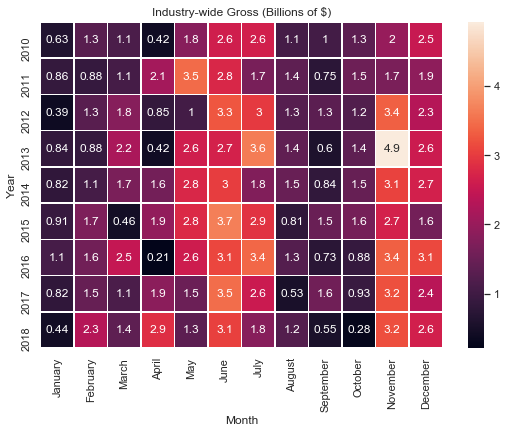

In [19]:
# Plotting a heat map for sum of worldwide_gross based on year and month of release.
sns.set()

# Create heatmap pivot table for plotting
p= df_genre_f.drop_duplicates(subset='original_title', keep="first", inplace=False)
heatmap_gb = p.groupby(['year', 'release_month']).sum()['worldwide_gross']
heatmap_unstack =heatmap_gb.unstack().apply(lambda x: x/(10**9))

# Drawing the heatmap
f, ax = plt.subplots(figsize=(9, 6))
x_axis_labels = ['January','February','March','April','May','June','July','August','September','October','November','December']
sns.heatmap(heatmap_unstack, annot=True, linewidths=.5, ax=ax, xticklabels=x_axis_labels)
plt.title('Industry-wide Gross (Billions of $)')
plt.xlabel('Month')
plt.ylabel('Year')


Ok, so clearly early summer and the end of the year are when consumers have the biggest appetite for watching movies.  But, if we are going to make a horror film, does this generalizationb hold true?  

Also, guess what came out in November of 2013... 

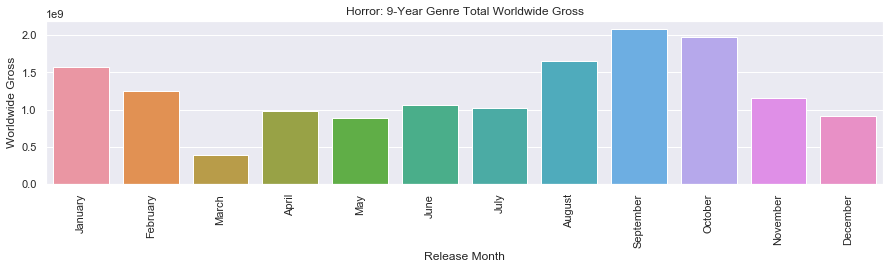

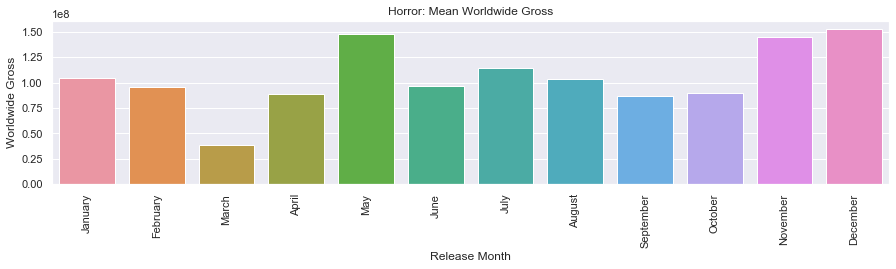

In [20]:
#Plotting the mean world_wide take for movies by release month 

genre_selector = 'Horror'

df_genre_f2 = df_genre_f.loc[df_genre['genre'] == genre_selector] 

#Plotting ms
for x in [0,1]:
    if x == 0:
        gb_genre = (df_genre_f2.groupby(['release_month']).sum())
    if x ==1:
        gb_genre = (df_genre_f2.groupby(['release_month']).mean())
    
    xvals = list(range(1, len(gb_genre) + 1))
    yvals = gb_genre['worldwide_gross'].values
    labels = gb_genre.index

    # Plotting
    plt.figure(figsize = (15,3))
    genre_plot = sns.barplot(x = labels, y = yvals, orient = 'v')
    x_axis_labels = ['January','February','March','April','May','June','July','August','September','October','November','December']
    genre_plot.set_xticklabels(x_axis_labels, rotation = 90, horizontalalignment = 'center')

    # Labeling 
    plt.xlabel('Release Month')
    plt.ylabel('Worldwide Gross')
   
    if x == 0:
        plt.title(f'{genre_selector}: 9-Year Genre Total Worldwide Gross')
    if x ==1:
        plt.title(f'{genre_selector}: Mean Worldwide Gross')

Interesting. While there is a lot of demand for horror films in September and October, the mean take on those movies is less than many months.  This must mean that these movies are crowded out in the time around Halloween. To avoid this competition I would suggest releasing in December. Perhaps the reason december Horror flicks do so well is that adults are looking for a change of pace after seeing Frozen-like family films for the 18th time.  Perhaps not.  Regardless, December it is. 

![scary christmas](https://media.giphy.com/media/fRhZWjRgqcbNSZRAp2/giphy.gif)

## Q2: Release Date:  Answer = December

# Question 3: Who do we hire?

Alright, we have the genre and the release date.  But, who do we need to actually need to make this first effort a success?  Let's start by creating a tool that creates a short list of actors, actresses, directors, writers and composers for our film.

In [21]:
# Re-establishing connection to mysql database
con = mysql.connector.connect(user = 'hbs-student', password = 'super-secure-password?',
                              host = 'hbs-ds-060120.c1doesqrid0e.us-east-1.rds.amazonaws.com',
                              database = 'movies')

In [22]:
# New SQL query to join movies and names tables
query = """
SELECT itb.*, bmg.*, tmb.release_date, tmb.worldwide_gross,
    tmb.production_budget, itc.directors, itc.writers, itp.job, itp.characters, itp.category as category_itp, inb.*
FROM movies.imdb_title_basics itb
JOIN movies.bom_movie_gross bmg
ON itb.primary_title = bmg.title
JOIN movies.tn_movie_budgets tmb
ON tmb.movie = bmg.title
Join movies.imdb_title_crew itc
ON itc.tconst = itb.tconst
Join movies.imdb_title_principals itp
ON itp.tconst = itc.tconst
Join movies.imdb_name_basics inb
ON inb.nconst = itp.nconst
"""
df_crew = pd.read_sql_query(query, con)


In [23]:
# Data cleaning and melt to get 'genre' string data into individual row entries.
df_crew = df_crew.genres.apply(lambda x: x.split(',')).apply(pd.Series)\
            .merge(df_crew, left_index = True, right_index = True)\
            .drop(["genres", 'primary_title', 'title'], axis = 1)\
            .melt(id_vars = ['tconst', 'original_title', 'start_year', \
                       'runtime_minutes', 'studio', 'domestic_gross', \
                       'foreign_gross', 'year', 'release_date', 'worldwide_gross', \
                       'production_budget', 'directors', 'writers', 'job', 'characters', \
                       'category_itp', 'nconst', 'primary_name', 'birth_year', 'death_year', \
                       'primary_profession', 'known_for_titles'], \
                              value_name = "genre")\
            .dropna(subset=['genre'])\
            .sort_values(by = 'genre')

# Split string on ',' into list and creating dataframe
# Merging new data fram with original df
# Dropping redunant columns
# Melting new genre columns into individual row entries
# Dropping rows with null 'genre' column 
# Sorting by genre

In [24]:
# Reformatting columns with string variables to int
dollar_string = ['worldwide_gross', 'production_budget']

for string in dollar_string:
    df_crew[string] = df_crew[string].str.replace("$", "").str.replace(',','').astype(int)

In [25]:
# Caluculating new columns ('roi' = Return on Investment)
df_crew['roi'] = (df_crew.worldwide_gross - df_crew.production_budget)/df_crew.production_budget

# Function definitions for presenting table and plotting 

In [26]:
def findcrew_table(data, job_role, movie_count, genre_select):
    # Filter for job Role
    if len(job_role) == 1:
        df_tcrew = df_crew.loc[(df_crew['category_itp'] == str(job_role[0]).lower())]
    if len(job_role) == 2:
        df_tcrew = df_crew.loc[(df_crew['category_itp'] == job_role[0]) | (df_crew['category_itp'] == job_role[1]) ]
    
    #Filtering for Genre
    if genre_select in ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy','Crime', 'Documentary', 'Drama',\
                        'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Romance',\
                        'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western']:  
        df_tcrew = df_tcrew.loc[(df_tcrew['genre'] == genre_select)]
    elif genre_select == 'All':
        df_tcrew = df_tcrew.drop_duplicates(subset=['original_title', 'primary_name', 'category_itp'], keep="first", inplace=False)
    
    #Group by  names
    tcrewCount_dict = df_tcrew.groupby(['primary_name']).count()['tconst'].to_dict()
    tcrewSum_dict = df_tcrew.groupby(['primary_name']).sum()['worldwide_gross'].to_dict()
    
    # New column for movie count
    df_tcrew['movie_count'] = df_tcrew['primary_name'].map(tcrewCount_dict)
    df_tcrew['total_worldwide'] = df_tcrew['primary_name'].map(tcrewSum_dict)
    
    # Filtering based on minimum movie count
    df_stars= df_tcrew.loc[df_tcrew.movie_count >=movie_count]
    
    # setting up the scatter plot
    df_stars_scatter = df_stars.groupby(['primary_name']).mean().sort_values(by = ['domestic_gross'], ascending = False)\
                                    [['worldwide_gross', 'production_budget', 'movie_count', 'total_worldwide']]
    # Group by names
    df_stars_select = df_stars.groupby('primary_name').mean()
    
    # Initializing the crew table 
    df_stars_table = pd.DataFrame()
    
    # Creating the table with top 10 in each cateogry and 
    threshold =[20000000, 100000000]
    df_stars_table['Rank'] = list(range(1,11))
    df_stars_table[f'{job_role[0].title()}: Indy Film'] = df_stars_select.loc[df_stars_select.production_budget < threshold[0]]\
                    .sort_values(by = 'roi', ascending = False).reset_index()['primary_name'].head(10)
    df_stars_table['ROI_IF'] = df_stars_select.loc[df_stars_select.production_budget < threshold[0]]\
                    .sort_values(by = 'roi', ascending = False).reset_index()['roi'].map(lambda x: round(x,1)).head(10)
    df_stars_table[f'{job_role[0].title()}:  Mainstream'] = df_stars_select.loc[(df_stars_select.production_budget > threshold[0])\
                    & (df_stars_select.production_budget < threshold[1])].sort_values(by = 'roi', ascending = False)\
                    .reset_index()['primary_name'].head(10)
    df_stars_table['ROI_MS'] = df_stars_select.loc[(df_stars_select.production_budget > threshold[0]) & \
                    (df_stars_select.production_budget < threshold[1])]\
                    .sort_values(by = 'roi', ascending = False).reset_index()['roi'].map(lambda x: round(x,1)).head(10)
    df_stars_table[f'{job_role[0].title()}:  Blockbuster'] = df_stars_select.loc[df_stars_select.production_budget > threshold[1]]\
                    .sort_values(by = 'roi', ascending = False).reset_index()['primary_name'].head(10)
    df_stars_table['ROI_BB'] = df_stars_select.loc[df_stars_select.production_budget > threshold[1]]\
                    .sort_values(by = 'roi', ascending = False).reset_index()['roi'].map(lambda x: round(x,1)).head(10)
    #return statement
    return df_stars_table, df_stars_scatter

In [27]:
def findcrew_graph(df_stars_scatter, job_title):
    
    # Plotter labels definition
    plotter_labels =list(df_stars_scatter.index)
    
    # Initializing the plot
    plt.figure(figsize =(10,10))
    sns.set_style("whitegrid")
    
    # Plotting scatterplot 
    plotter = sns.scatterplot(x=df_stars_scatter.production_budget, y=df_stars_scatter.worldwide_gross,\
                              hue = df_stars_scatter.movie_count, size = df_stars_scatter.total_worldwide,\
                             sizes=(25, 250))
    
    # Plotting ROI lines 
    slope = [1, 2, 3, 4, 5, 6] 
    x_0, y_0 = 0, 0
    x_1 = 250000000
    for s in slope:
        y_1 = s*(x_1 - x_0) + y_0
        plotter.plot([x_0, x_1], [y_0, y_1], 'black', ls='dashed', linewidth ='1', alpha =0.5) 

    # Plotting ROI labels.  Hard to iterate due to idiosyncratic label positioning and rotation
    plotter.text(220000000, 180000000, "ROI = 0", horizontalalignment='left', size='medium', color='black', weight='light', rotation = '9', alpha =0.5)
    plotter.text(220000000, 405000000, "ROI = 1", horizontalalignment='left', size='medium', color='black', weight='light', rotation = '16', alpha =0.5)
    plotter.text(220000000, 620000000, "ROI = 2", horizontalalignment='left', size='medium', color='black', weight='light', rotation = '25', alpha =0.5)
    plotter.text(220000000, 850000000, "ROI = 3", horizontalalignment='left', size='medium', color='black', weight='light', rotation = '32', alpha =0.5)
    plotter.text(220000000, 1070000000, "ROI = 4", horizontalalignment='left', size='medium', color='black', weight='light', rotation = '39', alpha =0.5)
    plotter.text(220000000, 1290000000, "ROI = 5", horizontalalignment='left', size='medium', color='black', weight='light', rotation = '43', alpha =0.5)
    
    # Plot details
    plt.title(f'{job_title} Gross ROI Plot')
    plt.xlabel('Mean Production Budget ($)')
    plt.ylabel('Mean Worldwide Gross ($)')
    plt.legend(title='Movies in 2010s', loc='upper left')
    
    # Setting up interactive plot tools.  Hover over points for data labels
    if 'mplcursors' in sys.modules:
        cursor = mplcursors.cursor(plotter, hover=True)

        @cursor.connect("add")
        def on_add(sel):
            sel.annotation.set_text(plotter_labels[sel.target.index])
            sel.annotation.set_bbox(None)
   
    #plt.show() 
    
    #Return Statement
    return plotter

In [28]:
def findcrew(job_title, movie_count, genre_sel):
    job = None
    if type(job_title) == list:
        job = job_title
    else: 
        job = [job_title]

    # running findcrew_table to get the table for printing
    tab, scatter = findcrew_table(df_crew, job, movie_count, genre_sel)
    
    # Running findcrew_graph for plottin purposes
    findcrew_graph(scatter, job_title)
    return tab
    

In [29]:
#Switch to interactive plots
%matplotlib inline

#Uncomment below if mplcursors install and want interactive plots
#if 'mplcursors' in sys.modules:
# %pylab
# %matplotlib qt

# Finding the Right Crew: General

,Rank,Actress: Indy Film,ROI_IF,Actress: Mainstream,ROI_MS,Actress: Blockbuster,ROI_BB
0,1,Ethan Hawke,15.5,Patrick Wilson,15.1,Chris Pratt,4.0
1,2,Octavia Spencer,8.2,Rose Byrne,11.7,Mark Ruffalo,4.0
2,3,Jennifer Garner,3.2,Catherine Keener,9.9,Vin Diesel,3.4
3,4,Brit Marling,2.9,Michael B. Jordan,6.6,Robert Downey Jr.,3.4
4,5,Emma Roberts,1.7,James McAvoy,6.3,Dwayne Johnson,3.1
5,6,Adam Driver,1.6,Shailene Woodley,6.1,Samuel L. Jackson,3.0
6,7,Susan Sarandon,1.4,Teresa Palmer,6.1,Leonardo DiCaprio,3.0
7,8,Kevin Kline,1.2,J.K. Simmons,5.7,Andy Serkis,2.9
8,9,Nicole Kidman,1.1,Rooney Mara,5.7,Willem Dafoe,2.7
9,10,Brian Cox,0.0,Mila Kunis,5.7,Anne Hathaway,2.5


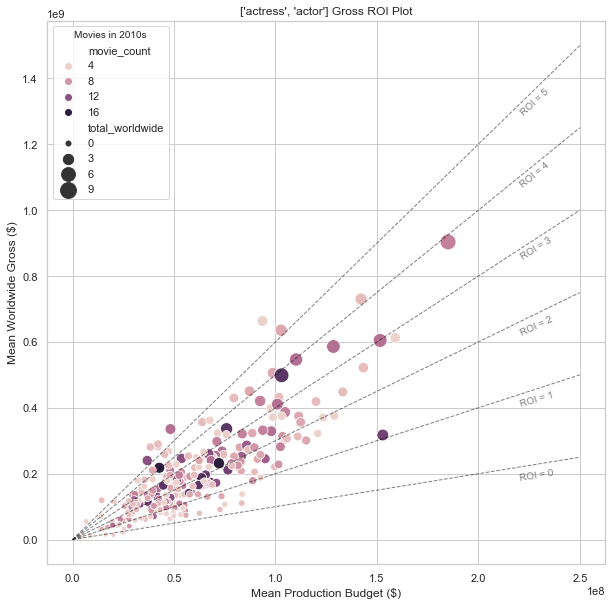

In [30]:
# Finding crew: Actors
findcrew(['actress', 'actor'], 5, 'All')

,Rank,Director: Indy Film,ROI_IF,Director: Mainstream,ROI_MS,Director: Blockbuster,ROI_BB
0,1,Ariel Schulman,23.5,James Wan,23.4,Bryan Singer,5.0
1,2,Henry Joost,23.5,M. Night Shyamalan,18.9,Anthony Russo,4.2
2,3,James DeMonaco,17.2,Scott Derrickson,11.1,Joe Russo,4.2
3,4,Christopher Landon,13.7,Damien Chazelle,10.6,Michael Bay,3.6
4,5,Michael Tiddes,10.2,Pierre Coffin,10.5,Francis Lawrence,3.4
5,6,Richard Linklater,6.9,Chris Renaud,9.8,Rich Moore,3.3
6,7,Derek Cianfrance,5.9,Ryan Coogler,9.3,Christopher Nolan,3.1
7,8,Eli Roth,5.4,Darren Aronofsky,8.9,Marc Webb,3.1
8,9,John Madden,5.3,Jake Kasdan,7.4,Mike Mitchell,3.0
9,10,J.C. Chandor,1.6,Steven Soderbergh,6.9,Carlos Saldanha,2.9


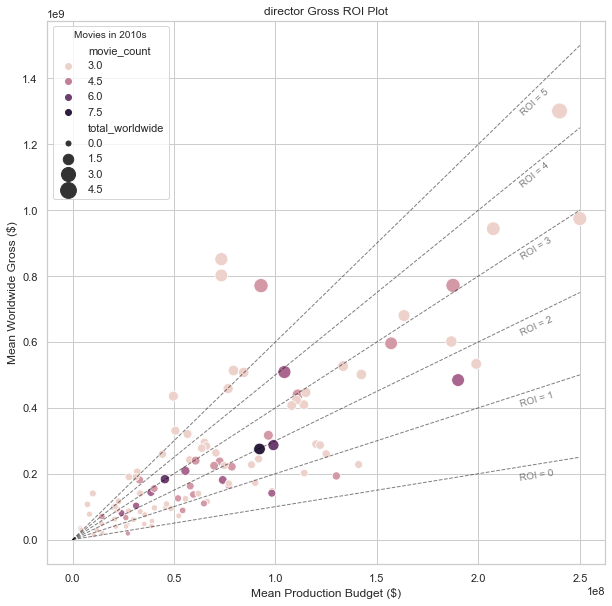

In [31]:
# Finding crew: Directors
findcrew('director', 3, 'All')

,Rank,Writer: Indy Film,ROI_IF,Writer: Mainstream,ROI_MS,Writer: Blockbuster,ROI_BB
0,1,Christopher Landon,42.0,C. Robert Cargill,11.9,Paul Wernick,6.9
1,2,Oren Peli,36.9,Eric Heisserer,11.7,Rhett Reese,6.9
2,3,Gary Dauberman,25.6,Ken Daurio,8.9,Suzanne Collins,5.3
3,4,Juliet Snowden,10.9,Cinco Paul,8.9,Chris McKenna,5.1
4,5,Rick Alvarez,10.2,Anthony McCarten,8.8,Erik Sommers,5.1
5,6,Michael H. Weber,8.6,E.L. James,8.3,Gary Scott Thompson,5.0
6,7,Scott Neustadter,8.6,Brian Lynch,7.7,Danny Strong,4.4
7,8,Abi Morgan,3.6,Mickey Rapkin,6.0,Jason Fuchs,4.2
8,9,Jeff Kinney,2.6,Kay Cannon,6.0,Derek Connolly,4.0
9,10,Stephen Susco,0.9,Andrew Jay Cohen,5.8,Michael Arndt,3.8


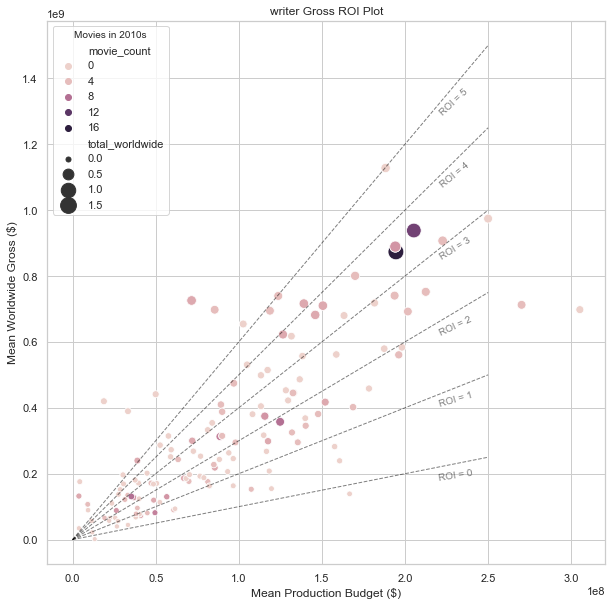

In [32]:
# Finding crew: Writers
findcrew('writer', 3, "All")

# Finding the Right Crew: Horror

,Rank,Actress: Indy Film,ROI_IF,Actress: Mainstream,ROI_MS,Actress: Blockbuster,ROI_BB
0,1,Katie Featherston,42.9,James McAvoy,27.3,NaN,NaN
1,2,Lin Shaye,40.7,Billy Burke,15.0,NaN,NaN
2,3,Patrick Wilson,40.2,Lucy Hale,13.8,NaN,NaN
3,4,Anya Taylor-Joy,21.8,Miranda Otto,9.8,NaN,NaN
4,5,Ashley Bell,21.7,Emily Blunt,9.3,NaN,NaN
5,6,Olivia Taylor Dudley,20.8,Ali Larter,5.5,NaN,NaN
6,7,Ethan Hawke,19.2,Ciarán Hinds,4.6,NaN,NaN
7,8,James Ransone,16.3,Milla Jovovich,4.6,NaN,NaN
8,9,Teresa Palmer,15.8,Daniel Radcliffe,3.7,NaN,NaN
9,10,Frank Grillo,11.1,Jessica Chastain,3.1,NaN,NaN


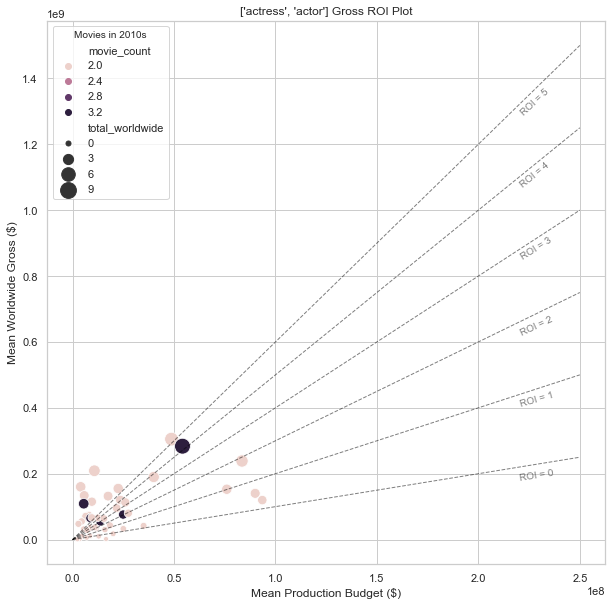

In [33]:
# Finding crew: Actors
findcrew(['actress', 'actor'], 2, 'Horror')

,Rank,Director: Indy Film,ROI_IF,Director: Mainstream,ROI_MS,Director: Blockbuster,ROI_BB
0,1,James Wan,40.2,Andy Muschietti,13.9,NaN,NaN
1,2,M. Night Shyamalan,36.8,Eli Roth,7.0,NaN,NaN
2,3,Ariel Schulman,34.0,Paul W.S. Anderson,4.6,NaN,NaN
3,4,Henry Joost,34.0,Wes Craven,0.5,NaN,NaN
4,5,David F. Sandberg,24.1,Wayne W. Whited,0.3,NaN,NaN
5,6,John R. Leonetti,19.7,NaN,NaN,NaN,NaN
6,7,Daniel Stamm,18.5,NaN,NaN,NaN,NaN
7,8,James DeMonaco,17.2,NaN,NaN,NaN,NaN
8,9,Scott Derrickson,15.1,NaN,NaN,NaN,NaN
9,10,Adam Wingard,14.4,NaN,NaN,NaN,NaN


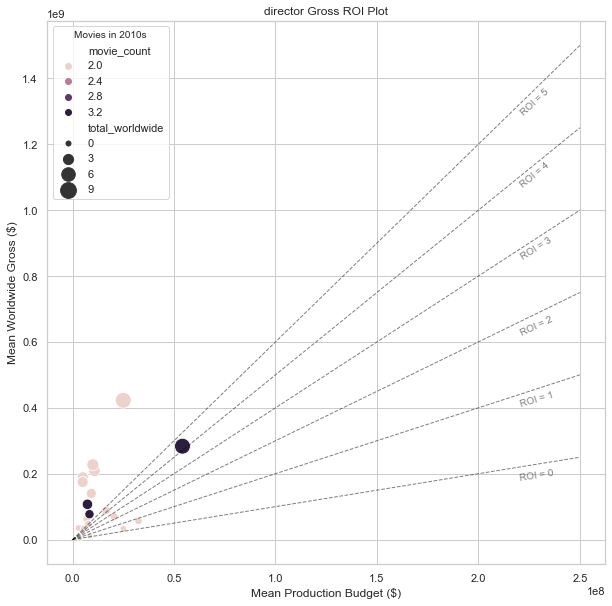

In [34]:
# Finding crew: Director
findcrew('director', 2, 'Horror')

,Rank,Writer: Indy Film,ROI_IF,Writer: Mainstream,ROI_MS,Writer: Blockbuster,ROI_BB
0,1,Christopher Landon,42.0,Eric Heisserer,15.8,NaN,NaN
1,2,Oren Peli,36.9,Matthew Robbins,0.5,NaN,NaN
2,3,Gary Dauberman,25.6,Seth Grahame-Smith,0.4,NaN,NaN
3,4,Andrew Gurland,21.7,R. David Burns,0.3,NaN,NaN
4,5,Huck Botko,21.7,Mary Shelley,-0.0,NaN,NaN
5,6,C. Robert Cargill,16.3,NaN,NaN,NaN,NaN
6,7,Simon Barrett,14.4,NaN,NaN,NaN,NaN
7,8,Damien Chazelle,13.0,NaN,NaN,NaN,NaN
8,9,Juliet Snowden,10.9,NaN,NaN,NaN,NaN
9,10,Jeff Howard,8.0,NaN,NaN,NaN,NaN


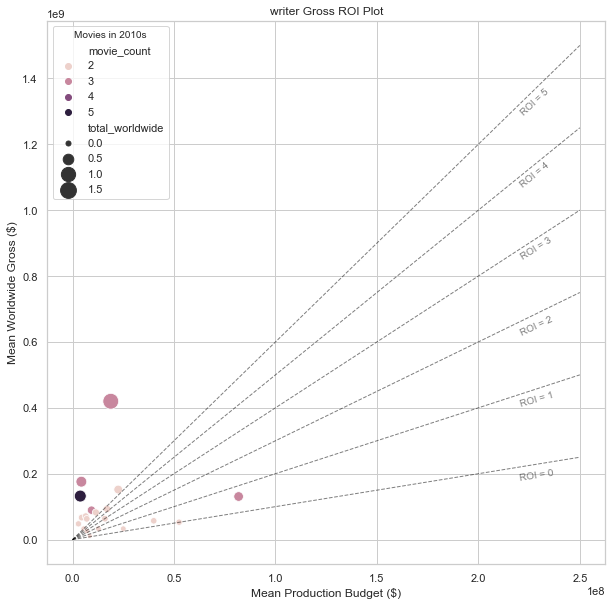

In [35]:
# Finding crew: Writer
findcrew('writer', 2, 'Horror')

In [36]:
df_crew.loc[df_crew.primary_name == 'James Wan'].drop_duplicates(subset = ['primary_name', 'original_title'])

,tconst,original_title,start_year,runtime_minutes,studio,domestic_gross,foreign_gross,year,release_date,worldwide_gross,...,category_itp,nconst,primary_name,birth_year,death_year,primary_profession,known_for_titles,variable,genre,roi
8912,tt2820852,Furious Seven,2015,137.0,Uni.,353000000.0,1.0,2015,"Apr 3, 2015",1518722794,...,director,nm1490123,James Wan,1977.0,NaN,"producer,writer,director","tt1457767,tt0387564,tt3065204,tt2820852",0,Action,6.993278
14108,tt1477834,Aquaman,2018,143.0,WB,335100000.0,812700000.0,2018,"Dec 21, 2018",1146894640,...,director,nm1490123,James Wan,1977.0,NaN,"producer,writer,director","tt1457767,tt0387564,tt3065204,tt2820852",0,Action,6.168092
11409,tt4786282,Lights Out,2016,81.0,WB (NL),67300000.0,81600000.0,2016,"Jul 22, 2016",148806510,...,producer,nm1490123,James Wan,1977.0,NaN,"producer,writer,director","tt1457767,tt0387564,tt3065204,tt2820852",0,Drama,28.761302
7513,tt3322940,Annabelle,2014,99.0,WB (NL),84300000.0,172800000.0,2014,"Oct 3, 2014",256862920,...,producer,nm1490123,James Wan,1977.0,NaN,"producer,writer,director","tt1457767,tt0387564,tt3065204,tt2820852",0,Horror,38.517372
2639,tt1591095,Insidious,2010,103.0,FD,54000000.0,43000000.0,2011,"Apr 1, 2011",99870886,...,director,nm1490123,James Wan,1977.0,NaN,"producer,writer,director","tt1457767,tt0387564,tt3065204,tt2820852",0,Horror,65.580591
5751,tt1457767,The Conjuring,2013,112.0,WB (NL),137400000.0,182100000.0,2013,"Jul 19, 2013",318000141,...,director,nm1490123,James Wan,1977.0,NaN,"producer,writer,director","tt1457767,tt0387564,tt3065204,tt2820852",0,Horror,14.900007
14378,tt5726086,Insidious: The Last Key,2018,103.0,Uni.,67700000.0,100100000.0,2018,"Jan 5, 2018",167885588,...,producer,nm1490123,James Wan,1977.0,NaN,"producer,writer,director","tt1457767,tt0387564,tt3065204,tt2820852",0,Horror,15.788559
12878,tt5140878,Annabelle: Creation,2017,109.0,WB (NL),102100000.0,204400000.0,2017,"Aug 11, 2017",305384865,...,producer,nm1490123,James Wan,1977.0,NaN,"producer,writer,director","tt1457767,tt0387564,tt3065204,tt2820852",0,Horror,19.358991


# Q4:  Who are the directors that can make the highest grossing flims, regardless of budget, for each of the worldwide and domestic markets?

Assuming that gaining ensuring large scale user traction for Microsoft's streaming service is the priority, it may be interested in hiring the best to make the biggest hits. This means irrespective of recovering the investment during the initial phase, Microsoft will want to create a blockbuster and go for marketshare.

We looked at both the worldwide market for theater releases and the domestic market for US streaming service, to see which directors are likely to gain the greatest market traction based on the track record in the past 10 years.

In [51]:
import mysql.connector

con = mysql.connector.connect(user='hbs-student', password='super-secure-password?',
                              host='hbs-ds-060120.c1doesqrid0e.us-east-1.rds.amazonaws.com',
                              database='movies')

In [52]:
query = """
 select itb.*, tmb.release_date, tmb.worldwide_gross, tmb.domestic_gross, tmb.production_budget,
		itc.*, itp.*, inb.*, itr.*
    
    from imdb_title_basics itb
    
	JOIN movies.bom_movie_gross bmg
	ON itb.primary_title = bmg.title

	JOIN movies.tn_movie_budgets tmb
	ON tmb.movie = bmg.title

    Join imdb_title_crew itc
    ON itc.tconst = itb.tconst

    Join imdb_title_principals itp
    ON itp.tconst = itc.tconst

    join imdb_name_basics inb
    on inb.nconst = itp.nconst
    
    join imdb_title_ratings itr
    on itr.tconst = itb.tconst
    
where worldwide_gross IS NOT null 
"""
df =pd.read_sql_query(query, con)

In [53]:
df.shape

(14296, 28)

In [40]:
# data cleaning

# dropping duplicates to leave director information only
gross = df.loc[df['category'] == 'director'].drop_duplicates(subset=('tconst'))

# converting gross revenues to float
gross['domestic_gross_int'] = gross['domestic_gross'].str.replace('$', '').str.replace(',','').astype(float)
gross['worldwide_gross_int'] = gross['worldwide_gross'].str.replace('$', '').str.replace(',','').astype(float)

In [49]:
gross.shape

(1398, 30)

In [43]:
#highest grossing films in the past 5 years

#worldwide
wwg_f = gross.nlargest(50, 'worldwide_gross_int')
wwg_m = wwg_f[['primary_name','primary_title', 'start_year','worldwide_gross_int']] \
    .sort_values('worldwide_gross_int', ascending = False)
wwg_m

#domestic
#worldwide
dmg_f = gross.nlargest(50, 'domestic_gross_int')
dmg_m = dmg_f[['primary_name','primary_title', 'start_year','domestic_gross_int']] \
    .sort_values('domestic_gross_int', ascending = False)
dmg_m

,primary_name,primary_title,start_year,domestic_gross_int
1483,Ryan Coogler,Black Panther,2018,700059566.0
1073,Anthony Russo,Avengers: Infinity War,2018,678815482.0
5326,Colin Trevorrow,Jurassic World,2015,652270625.0
4707,Brad Bird,Incredibles 2,2018,608581744.0
8446,Gareth Edwards,Rogue One: A Star Wars Story,2016,532177324.0
3422,Andrew Stanton,Finding Dory,2016,486295561.0
1063,Joss Whedon,Avengers: Age of Ultron,2015,459005868.0
10377,Christopher Nolan,The Dark Knight Rises,2012,448139099.0
11268,Francis Lawrence,The Hunger Games: Catching Fire,2013,424668047.0
5336,J.A. Bayona,Jurassic World: Fallen Kingdom,2018,417719760.0


In [44]:
# Worldwide top 5 grossing directors
# count of top 50 grossing films by director
wwg_n = wwg_m['primary_name'].value_counts()
wwg_n = wwg_n.sort_index()
wwg_n = wwg_n.to_frame().rename(columns={'primary_name':'count'})

# total gross revenue by director from top 50 worldwide grossing films
wwg_t = wwg_m.groupby('primary_name')['worldwide_gross_int'].sum()  
wwg_t = wwg_t.to_frame().rename(columns={'worldwide_gross_int':'total_gross'})

# average gross revenue per film by director
wwg_a = wwg_m.groupby('primary_name')['worldwide_gross_int'].mean()
wwg_a = wwg_a.to_frame().rename(columns={'worldwide_gross_int':'average_per_film'})

# joining the dataframes
wwg = pd.concat([wwg_n, wwg_t, wwg_a], axis=1, join='inner')
wwg = wwg.reset_index().rename(columns={'index':'primary_name'})
wwg = wwg.sort_values(by='total_gross', ascending=False).nlargest(5,'total_gross')
wwg

,primary_name,count,total_gross,average_per_film
4,Anthony Russo,2,3.188204e+09,1.594102e+09
31,Peter Jackson,3,2.922948e+09,9.743160e+08
21,James Wan,2,2.665617e+09,1.332809e+09
27,Michael Bay,2,2.227830e+09,1.113915e+09
25,Kyle Balda,2,2.195064e+09,1.097532e+09


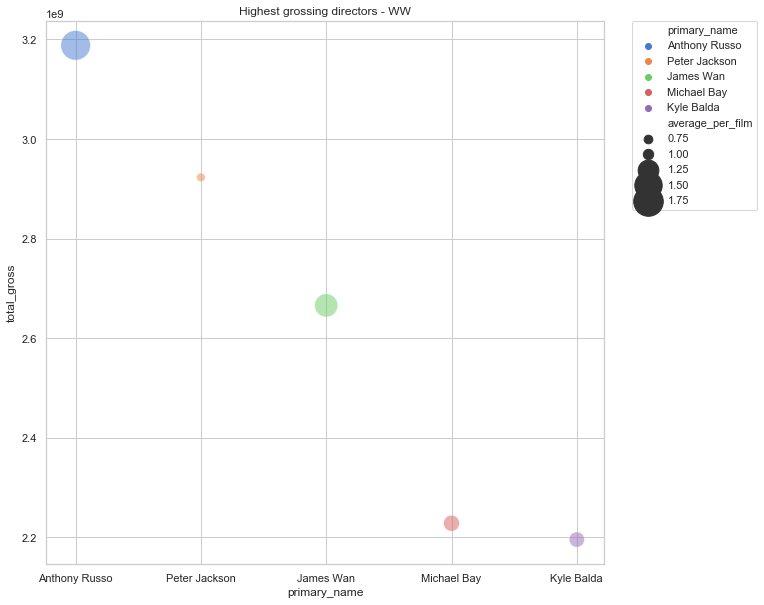

In [45]:
# categorical scatter plot with varying point sizes
plt.figure(figsize =(10,10))

ax = sns.scatterplot(y="total_gross", size='average_per_film', hue='primary_name', x="primary_name", data=wwg, sizes=(75,175*5), alpha=.5, palette="muted")\
.set_title('Highest grossing directors - WW')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Q4 highest grossing director - worldwide: Anthony Russo (Avengers) 

In [46]:
# Domestic top 5 highest grossing directors

# count of top 50 grossing films by director
dmg_n = dmg_m['primary_name'].value_counts()
dmg_n = dmg_n.sort_index()
dmg_n = dmg_n.to_frame().rename(columns={'primary_name':'count'})

# total gross revenue by director from top 50 worldwide grossing films
dmg_t = dmg_m.groupby('primary_name')['domestic_gross_int'].sum()  
dmg_t = dmg_t.to_frame().rename(columns={'domestic_gross_int':'total_gross'})

# average gross revenue per film by director
dmg_a = dmg_m.groupby('primary_name')['domestic_gross_int'].mean()
dmg_a = dmg_a.to_frame().rename(columns={'domestic_gross_int':'average_per_film'})

# joining the dataframes
dmg = pd.concat([dmg_n, dmg_t, dmg_a], axis=1, join='inner')
dmg = dmg.reset_index().rename(columns={'index':'primary_name'})
dmg = dmg.sort_values(by='total_gross', ascending=False).nlargest(5,'total_gross')
dmg

,primary_name,count,total_gross,average_per_film
5,Anthony Russo,2,1.086900e+09,5.434499e+08
18,Francis Lawrence,3,1.043528e+09,3.478426e+08
12,Christopher Nolan,2,7.407153e+08,3.703576e+08
37,Ryan Coogler,1,7.000596e+08,7.000596e+08
25,James Wan,2,6.880688e+08,3.440344e+08


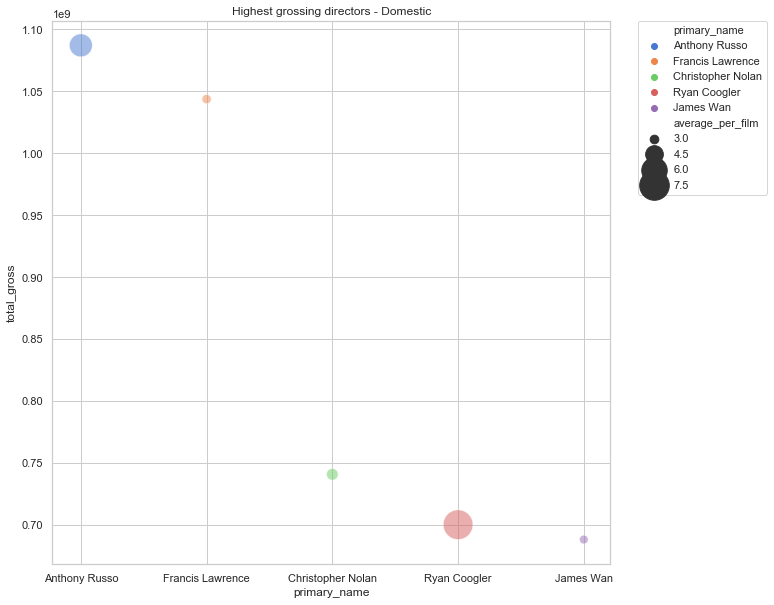

In [47]:
# categorical scatter plot with varying point sizes
plt.figure(figsize =(10,10))

ax = sns.scatterplot(y="total_gross", size='average_per_film', hue='primary_name', x="primary_name", data=dmg, sizes=(75,175*5), alpha=.5, palette="muted")\
.set_title('Highest grossing directors - Domestic')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Q4 highest grossing director - Domestic: Ryan Coogler (Black Panther) 

'End of Notebook'